#### Simulating the travelling salesman problem with three cities.

* Cost Matrix

In [1]:
K = [0, 2, 3, 4, 0, 6, 7, 8, 0]

* Importing important libraries

In [2]:
from qiskit import *
from qiskit.circuit import parameter
from qiskit.circuit import ParameterVector, Parameter
from qiskit.visualization import plot_histogram
from IPython.core.display import Latex
from qiskit_algorithms.optimizers import ADAM
from qiskit_algorithms.gradients import SPSAEstimatorGradient
from qiskit_aer import AerSimulator, StatevectorSimulator
import numpy as np
import ot
import re
from qiskit.circuit.library.standard_gates import RXGate, RYGate, RZGate

* Parameters

In [27]:
# Number of cities
n = 3
beta_para = (2 * np.pi * np.random.rand(1))           # Beta parameters
theta1_val = [(2 * np.pi * np.random.rand(1))[0] for i in range(n*n)]    # Perceptron layers 1st parameters
theta2_val = [(2 * np.pi * np.random.rand(1))[0] for i in range(n*n)]   # Perceptron layers 2nd parameters
alpha_val = [(2 * np.pi * np.random.rand(1))[0] for i in range(n*n)]       # Alpha parameters for pooling layer

# Combining all the lists
paras_values = theta1_val + theta2_val + alpha_val

In [4]:
# beta_para = Parameter(r'$\beta$')   # Constraint layers Parameter
theta1 = Parameter(r'$\theta_1$')     # Perceptron layers 1st parameter
theta2 = Parameter(r'$\theta_2$')     # Perceptron layers 2nd parameter
alpha = Parameter(r'$\alpha$')      # Alpha parameters for pooling layer

In [26]:
class TSP_Solver:
    def __init__(self, reference_circuit, variational_circuit,MCRX, n, K, theta1, theta2, alpha, matching_matrix):
        self.ref_cir = reference_circuit
        self.var_cir = variational_circuit
        self.MCRX = MCRX
        self.n = n
        self.n1 = n*n  # Squared of number of cities
        self.K = K
        self.alpha = alpha
        self.theta1 = theta1
        self.theta2 = theta2
        self.matching_matrix = matching_matrix  # A constraint matrix for matching with the ground truth
    
    "Creating an object of encoding layer"
    def encoding_layer(self):
        for q in range(len(self.K)):
            self.ref_cir.ry(self.K[q], q)
        self.ref_cir.barrier()
            
            
    "Defining contraint layer"
    def constraint_layer(self): 
        self.var_cir.append(self.MCRX, [1, 2, 3, 6, 0])    # rotation on qbit_1
        self.var_cir.append(self.MCRX, [0, 2, 4, 7, 1])    # rotation on qbit_2
        self.var_cir.append(self.MCRX, [0, 1, 5, 8, 2])    # rotation on qbit_3
        self.var_cir.append(self.MCRX, [0, 6, 4, 5, 3])    # rotation on qbit_4
        self.var_cir.append(self.MCRX, [1, 7, 3, 5, 4])    # rotation on qbit_5
        self.var_cir.append(self.MCRX, [2, 3, 4, 8, 5])    # rotation on qbit_6
        self.var_cir.append(self.MCRX, [0, 3, 7, 8, 6])    # rotation on qbit_7
        self.var_cir.append(self.MCRX, [1, 4, 6, 8, 7])    # rotation on qbit_8
        self.var_cir.append(self.MCRX, [6, 7, 2, 5, 8])    # rotation on qbit_9
        self.var_cir.barrier()
    
    "Perceptron layer"
    def perceptron_layer(self):
        rz = RZGate(self.theta1)
        ry = RYGate(self.theta2)
        for q in range(self.n1):
            self.var_cir.append(rz, [q])
            self.var_cir.append(ry, [q])
        self.var_cir.barrier()
               
    'Pooling Layer'
    def pooling_layer(self):
        ry = RYGate(self.alpha)
        for q in range(self.n1):
            self.var_cir.append(ry, [q])
    
    'composing the reference and variational circuits'
    # The circuit can be visualized as well from here.
    def ansatz(self):
        ansat = self.ref_cir.compose(self.var_cir)
        ansat.measure_all()
        return ansat
    
    'Statvector simulating'
    def statevect(self):
        simulator = StatevectorSimulator()
        result= simulator.run(transpile(self.ansatz(), simulator), shots = 1000).result()
        statevector = result.get_statevector()
        return statevector.draw('latex')
    
    'Reshaping result to matrix'
    def x_matrix(self):
        latex_string = self.statevect().data     # Stores the statevector as a latex string5
        latex_list = list(latex_string)        # This object stores the statevector as a list
        
        'Extracting only the states of the qubits'
        a = latex_list.index('|')
        b = latex_list.index('\\')
        y = latex_list[a+1:b]
        y1 = np.array([int(i) for i in y])
        Y1 = y1.reshape(self.n, self.n)  # Reshaping the measured states of qubits to a matrix 
        
        # Define the size of marginals
        n = Y1.shape[0]
        m = Y1.shape[1]
        
        # Define the cost matrix with the matching constraint
        cost_matrix = np.multiply(Y1, self.matching_matrix) # Element-wise multiplication to zero out non-matching elements

        # Apply Sinkhorn algorithm to converge to a doubly stochastic matrix with the matching constraint
        X_ds = ot.sinkhorn(np.ones(n) / n, np.ones(m) / m, cost_matrix, reg=0.01)
        return X_ds
    
    'Creating the cost function as cross-entrophy loss'
    def cost_fun(self):
        """Cost function of circuit parameters on training data.
            The optimizer will attempt to minimize this."""
        'Objective function'
        def objective_func():
            loss = 0
            X = list(self.matching_matrix.flatten())
            Y = list(self.x_matrix().flatten())
            for i in range(len(X)):
                loss += (-X[i]*np.log(Y[i]) + (1-X[i])*np.log(1-Y[i]))
            return loss
        return objective_func


#### Calling the whole class here
* Number of Cities 'n'
* Quantum circuit 
* Applying Hadammard to all qubits

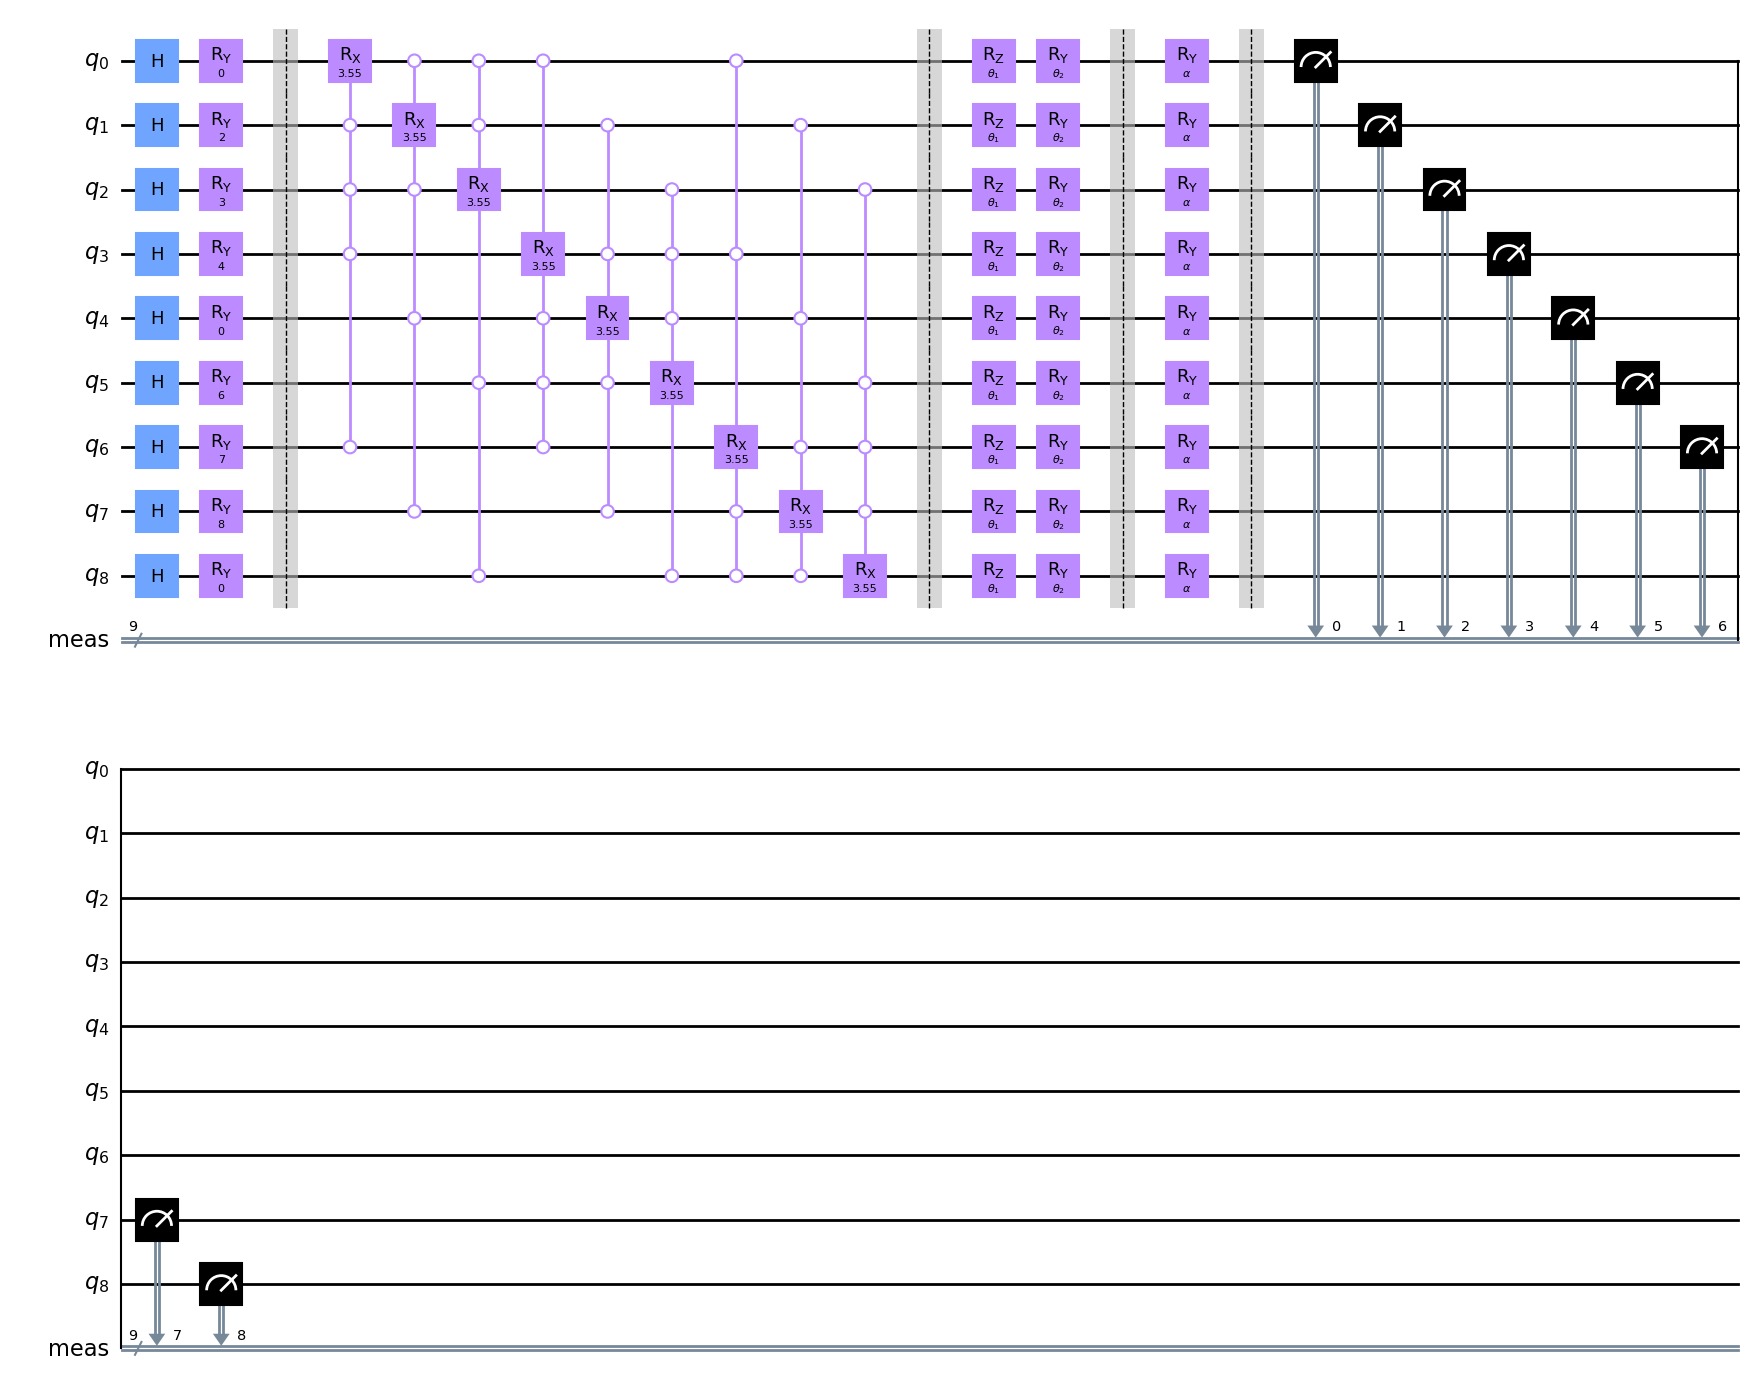

In [10]:
def call_pass_obj_fun(TSP):
    TSP.encoding_layer()
    TSP.constraint_layer()
    TSP.perceptron_layer()
    TSP.pooling_layer()
    return TSP.ansatz().draw('mpl')
#     TSP.statevect()
#     TSP.x_matrix()
#     obj = TSP.cost_fun()
#     return obj
    
    
# Define the matching constraint
m_c = np.array([[0, 1, 0],
                [1, 0, 0],
                [0, 0, 1]])

reference_circuit = QuantumCircuit(n*n)      # Circuit to which data be encoded
reference_circuit.h([i for i in range(n*n)])     
variational_circuit = QuantumCircuit(n*n)     # Circuit for

#Preparing the multi-controlled X rotational gat
MCRX=RXGate(beta_para).control(4, ctrl_state='0000')

TSP = TSP_Solver(reference_circuit, variational_circuit, MCRX, n, K, theta1, theta2, alpha, m_c)
call_pass_obj_fun(TSP)

###### A main function from where the whole class or TSP-Simulation be controlled

In [100]:
# Main Function
def main():
    
    class optimizerlog:
        """Log to store optimizer's intermediate results"""
        def __init__(self):
            self.evaluations = []
            self.parameters = []
            self.costs = []
        def update(self, evaluation, parameter, cost, _stepsize, _accept):
            """Save intermediate results. Optimizer passes five values
            but we ignore the last two."""
            self.evaluations.append(evaluation)
            self.parameters.append(parameter)
            self.costs.append(cost)

    log = optimizerlog()
    intial_paras = (2 * np.pi * np.random.rand(27)).tolist()
    
    # Creating the adam optimizer and minimizing the cross-entropy function
    adam = ADAM(maxiter=100,tol=1e-06, lr=0.001, beta_1=0.9, beta_2=0.99,
                noise_factor=1e-08, eps=1e-10, amsgrad=False, snapshot_dir=None)
    result = adam.minimize(call_pass_obj_fun(TSP), intial_paras)

if __name__ == '__main__':
    main()

AerError: 'circuits have parameters but parameter_binds is not specified.'

In [87]:
!git add .
!git commit -m "Your commit message"

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
  (commit or discard the untracked or modified content in submodules)
	modified:   pyconcorde (modified content)

no changes added to commit (use "git add" and/or "git commit -a")


In [88]:
!git push -u origin main

branch 'main' set up to track 'origin/main'.


To https://github.com/Sajjad-Ahmad-phy/Final-Year-Project.git
   b1dfb90..d8dfa5b  main -> main
